# Circuit Net train for Single-stage VC-OTA


The circuit nelist can be at (https://github.com/nunocclourenco/BAIcO/blob/main/circuit_examples/ptm130_ssvcamp_ngspice/ssvcamp.cir), however that was not the setup used to gather this data. The data used for SMACD paper was generated using proprietary tools and PDKs.

In [1]:
## Imports and Global Inits
import joblib
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from datetime import datetime


from circuit_net import *

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
tf.random.set_seed(seed)

2022-03-25 11:15:50.199895: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-25 11:15:50.200066: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Dataset

- Load dataset
- Scale dataset

In [2]:

dataframe = pd.read_csv("../data/ssvcamplifier(umc_013)_dataset_v2.csv")

Y = dataframe[['w8','w6','w4','w10','w1','w0','l8','l6','l4','l10','l1','l0']]
X = dataframe[['gdc','idd','gbw','pm']]

# augmentate data set
# C repeat Y after scaling as they are not modified in the augmentation procedure
X_scaled, Y_scaled, scalers = scale_data(X.values, Y.values)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y_scaled,
                                                    test_size = 0.2,
                                                    random_state = seed)

print(X.max())
print(X.min())

print(X.values.shape)
print(X_train.shape)
print(X_test.shape)



gdc    5.678000e+01
idd    3.952600e-04
gbw    7.813500e+07
pm     7.970700e+01
dtype: float64
gdc    4.472900e+01
idd    2.208800e-04
gbw    3.424000e+07
pm     6.000000e+01
dtype: float64
(16661, 4)
(13328, 15)
(3333, 15)


In [3]:
joblib.dump(scalers["X_poly"], '../models/VCOTA_X_poly.pkl')
joblib.dump(scalers["X_scaler"], '../models/VCOTA_X_scaler.pkl')
joblib.dump(scalers["Y_scaler"], '../models/VCOTA_Y_scaler.pkl')

['../models/VCOTA_Y_scaler.pkl']

2022-03-25 11:15:52.541967: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-25 11:15:52.542192: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-25 11:15:52.542333: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-BHJQ8M4): /proc/driver/nvidia/version does not exist
2022-03-25 11:15:52.544547: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


loss-train	 0.009046998806297779
loss-val 	 0.009086128324270248


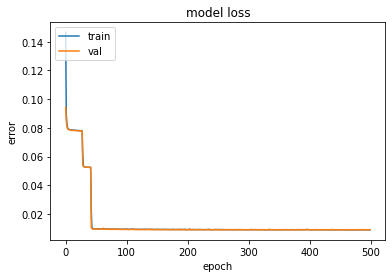

mae-train	 0.058798808604478836
mae-val 	 0.05991609767079353


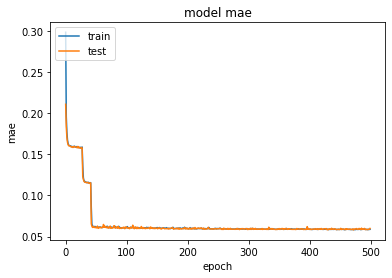

In [4]:
#model with the short train
model = build_dense_model((15, 120, 240, 60, 12), activation='relu', l2_lambda=1.3e-5)

#Starting Time
history = model.fit(X_train, 
                    y_train, 
                    validation_data = (X_test,y_test),
                    epochs = 500, 
                    batch_size= 512, 
                    verbose = 0)
show_history(history)

In [5]:
#save the model parameters
date_str = '{:%Y%m%d%H%M}'.format(datetime.now())
model_1 = model.save_weights('../models/circuit-net-vcota-'+date_str+'.h5') # save the model as abcd.h5


In [6]:
#make some predictions
lablels = ['_w8','_w6','_w4','_w10','_w1','_w0','_l8','_l6','_l4','_l10','_l1','_l0']

wishlist = augment_specs(
     np.array([[50, 0.0002, 50e6, 60]]),
    np.array([1,-1, 1, 1]), 
    20, 0.1
)

with open("../results/ann_predictions_in_range.log", "w") as text_file:
    print (format_circuit(predict_circuit(wishlist,model, scalers, True),lablels), file=text_file)

loss-train	 0.008832350373268127
loss-val 	 0.009055323898792267


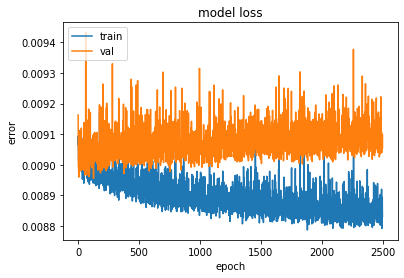

mae-train	 0.057180747389793396
mae-val 	 0.05822904035449028


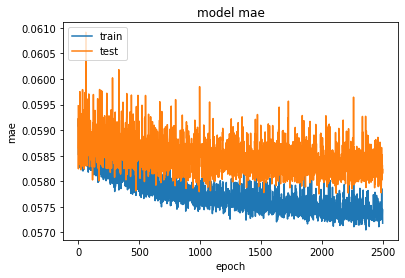

In [7]:
#train a bit more 
history = model.fit(X_train, 
                    y_train, 
                    validation_data = (X_test,y_test),
                    epochs = 2500, 
                    batch_size= 512, 
                    verbose = 0)
show_history(history)

In [8]:
wishlist = augment_specs(
     np.array([[43, 0.0004, 100e6, 60]]),
    np.array([1,-1, 1, 1]), 
    20, 0.1
)


with open("../results/ann_predictions_100MH_more_train.log", "w") as text_file:
    print (format_circuit(predict_circuit(wishlist,model, scalers, True),lablels), file=text_file)

loss-train	 0.0041938959620893
loss-val 	 0.011607113294303417


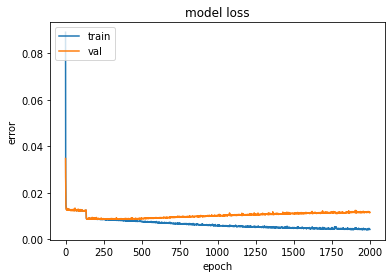

mae-train	 0.04149393364787102
mae-val 	 0.06415267288684845


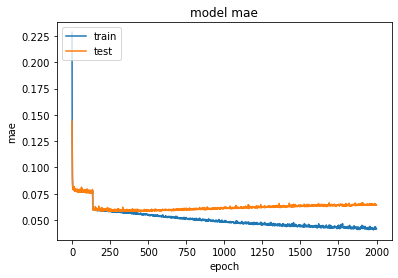

In [9]:
# Overfit vs Regularization
np.random.seed(7)
model_overfit = build_dense_model((15, 480, 240, 60, 12), activation='relu', l2_lambda=0)

#Starting Time
history_overfit = model_overfit.fit(X_train, 
                    y_train, 
                    validation_data = (X_test,y_test),
                    epochs = 2000, 
                    batch_size= 512, 
                    verbose = 0)
show_history(history_overfit)

loss-train	 0.00885405857115984
loss-val 	 0.009061355143785477


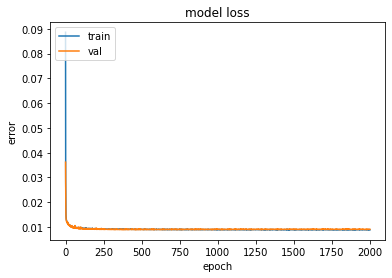

mae-train	 0.05744711682200432
mae-val 	 0.05818772315979004


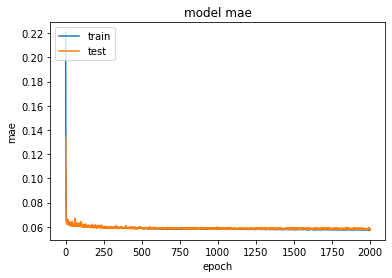

In [10]:
np.random.seed(7)
model_l2_reg = build_dense_model((15, 480, 240, 60, 12), activation='relu', l2_lambda=1.3e-5)

#Starting Time
history_l2_reg = model_l2_reg.fit(X_train, 
                    y_train, 
                    validation_data = (X_test,y_test),
                    epochs = 2000, 
                    batch_size= 512, 
                    verbose = 0)
show_history(history_l2_reg)

loss-train	 0.0032328476663678885
loss-val 	 0.012630282901227474


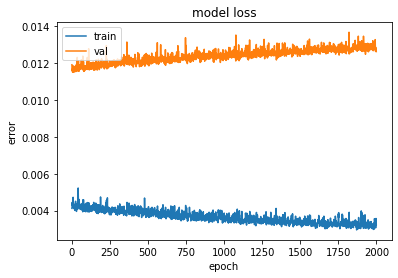

mae-train	 0.0368465781211853
mae-val 	 0.06649291515350342


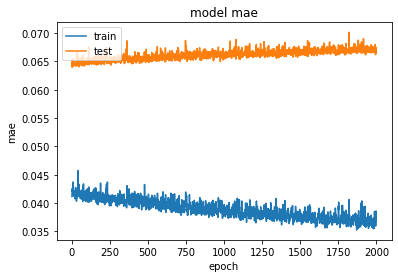

loss-train	 0.008799311704933643
loss-val 	 0.009111112914979458


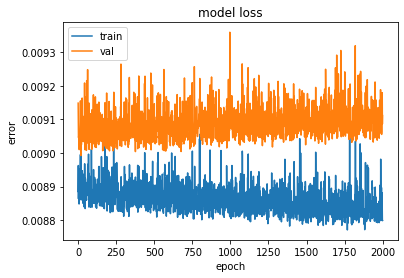

mae-train	 0.057035889476537704
mae-val 	 0.0580686554312706


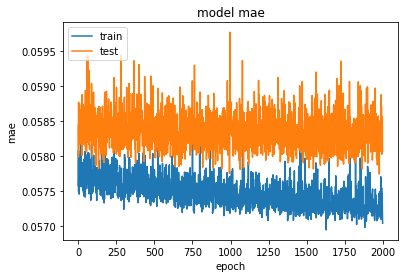

In [11]:
#train a bit more
history_overfit2 = model_overfit.fit(X_train, 
                    y_train, 
                    validation_data = (X_test,y_test),
                    epochs = 2000, 
                    batch_size= 512, 
                    verbose = 0)
show_history(history_overfit2)

#Starting Time
history_l2_reg2 = model_l2_reg.fit(X_train, 
                    y_train, 
                    validation_data = (X_test,y_test),
                    epochs = 2000, 
                    batch_size= 512, 
                    verbose = 0)
show_history(history_l2_reg2)


In [12]:
#save model parameters
date_str = '{:%Y%m%d%H%M}'.format(datetime.now())

model_l2_reg.save_weights('../models/CircuitNet-VCOTA-v1_15_480_240_60_12-'+date_str+'.h5') # save the model as abcd.h5

loss-train	 0.11833495646715164
loss-val 	 0.06221490725874901


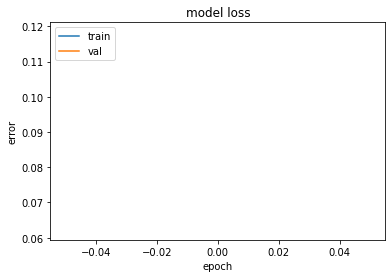

mae-train	 0.261181116104126
mae-val 	 0.17280460894107819


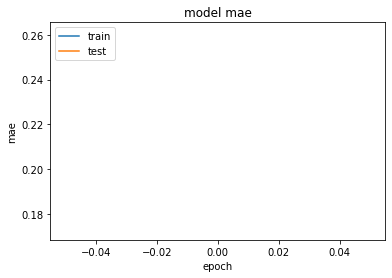

loss-train	 0.009995521977543831
loss-val 	 0.009825160726904869


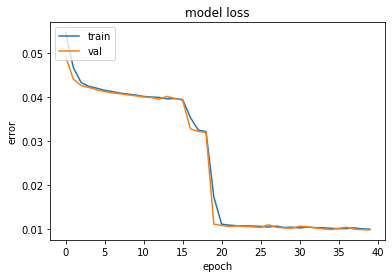

mae-train	 0.06132933124899864
mae-val 	 0.06063535436987877


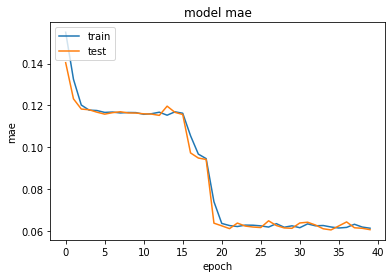

In [13]:
# Larger Regularization factor
np.random.seed(7)
model2_l2_reg = build_dense_model((15, 480, 240, 60, 12), activation='relu', l2_lambda=2e-5)

#Starting Time
history2_l2_reg = model2_l2_reg.fit(X_train, 
                    y_train, 
                    validation_data = (X_test,y_test),
                    epochs = 1, 
                    batch_size= 512, 
                    verbose = 0)
show_history(history2_l2_reg)
history2_l2_reg2 = model2_l2_reg.fit(X_train, 
                    y_train, 
                    validation_data = (X_test,y_test),
                    epochs = 40, 
                    batch_size= 512, 
                    verbose = 0)
show_history(history2_l2_reg2)




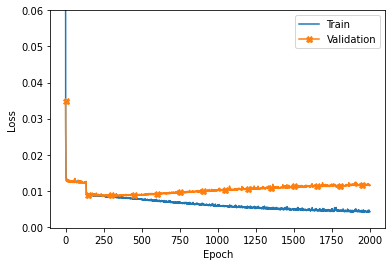

/tmp/ipykernel_13347/288392586.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


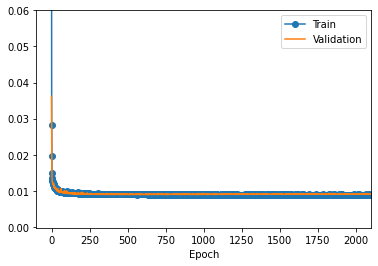

In [14]:
metric = 'loss'


# summarize history for metric
f, ax1 = plt.subplots(1, 1, sharey=True)

ax1.plot(history_overfit.history[metric] , '-')
ax1.plot(history_overfit.history['val_'+metric] , '-X', markevery=150)
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')

#plt.show()
axis = ax1.axis()
axis = (axis[0],axis[1],axis[2], 0.06)
ax1.axis(axis)
ax1.legend(['Train', 'Validation'], loc='upper right')
plt.savefig(metric + 'overfit.png', dpi=600)
plt.show()


data1 = history_l2_reg.history[metric] + history_l2_reg2.history[metric]
data2 = history_l2_reg.history['val_'+metric] + history2_l2_reg2.history['val_'+metric]
f, ax2 = plt.subplots(1, 1, sharey=True)
data1 = history_l2_reg.history[metric] + history_l2_reg2.history[metric]
data2 = history_l2_reg.history['val_'+metric] + history_l2_reg2.history['val_'+metric]

# summarize history for metric

ax2.plot(data1, 'o-')
ax2.plot(data2, '-')

ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper right')
#plt.show()
ax2.axis(axis)
f.savefig(metric + '.png', dpi=300)
f.show()


<small>Copyright (c) 2022 Nuno Lourenço - Instituto de Telecomunicações.</small>